## Experimentación

In [8]:
import warnings
warnings.filterwarnings('ignore')
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [9]:
### Entender cantidad de datos con los que se trabaja ###
# Cargar el dataset
df_tweets = pd.read_csv('./Datasets/Originales/Tweets_calificados_modelo1.csv')

# Diccionario de palabras con sus puntajes personalizados
word_sentiment_scores = {
    'lluvia': -0.75, 'nublado': -0.25, 'tormenta': -0.50, 'viento': -0.25, 'granizo': -0.75,  # Clima
    'accidente': -0.50, 'choque': -0.75, 'derrape': -0.25, 'atropello': -1.50,  # Accidentes vehiculares
    'tráfico': -0.25, 'atasco': -0.15, 'congestión': -0.10, 'embotellamiento': -0.10,  # Problemas de tráfico
    'inundación': -1.25, 'desborde': -1.25, 'charco': -0.15, 'encharcamiento': -0.25,  # Problemas por agua
    'apagón': -1.25, 'falla': -0.10, 'electricidad': -0.15, 'corte': -0.15, 'colapso': -0.75,  # Problemas eléctricos
    'evacuación': -1.50, 'rescate': -0.75, 'desalojo': -1.50,  # Emergencias
    'muertos': -1.75, 'heridos': -1.00, 'destrucción': -0.75, 'incendio': -1.25,  # Consecuencias graves
    'explosión': -0.75, 'caos': -1.25, 'derrumbes': -1.50, 'colapsos': -1.50,  # Otros desastres
    'afectados': -0.25, 'perdidas': -0.50, 'daños': -0.75, 'colisión': -0.75,  # Impactos generales
    'caída': -0.25, 'árboles': -0.05, 'postes': -0.05, 'barrido': -0.75,  # Daños materiales
    ### Nuevas palabras clave (Aún negativas) ###
    'cierre': -0.50, 'bloqueo': -0.45, 'obstrucción': -0.25, 'restricción': -0.05,  # Cierres y bloqueos
    'retraso': -0.25, 'demora': -0.15, 'tardanza': -0.10, 'espera': -0.05,  # Retrasos
    'lento': -0.10, 'lentitud': -0.10, 'demorado': -0.15, 'atrasado': -0.20,  # Lentitud
    ### Nuevas palabras clave (Positivas) ###
    'despejado': 0.25, 'soleado': 0.25, 'bueno': 0.25, 'tranquilo': 0.25,  # Clima
    'fluido': 0.10, 'rápido': 0.10, 'despejado': 0.10, 'normal': 0.05,  # Tráfico
    'normal': 0.05, 'regular': 0.10, 'bueno': 0.25, 'excelente': 0.50,  # Calidad del servicio
    'rápido': 0.10, 'eficiente': 0.25, 'óptimo': 0.50, 'excelente': 0.75,  # Rendimiento
    'seguro': 0.25, 'protegido': 0.25, 'resguardado': 0.25, 'salvo': 0.25,  # Seguridad
    'salvo': 0.25, 'resguardado': 0.25, 'protegido': 0.25, 'seguro': 0.25,  # Protección
}

# Convertir el diccionario en una lista de palabras (sin los puntajes)
word_list = list(word_sentiment_scores.keys())

# Crear una función para contar la cantidad de veces que aparece cada palabra en la columna 'Texto'
def count_words_in_text(text, word_list):
    word_count = {word: text.lower().count(word) for word in word_list}
    return pd.Series(word_count)

# Aplicar la función a cada fila de la columna 'Texto'
df_word_counts = df_tweets['Texto'].apply(lambda text: count_words_in_text(text, word_list))

# Ahora vamos a sumar los conteos de todas las filas para obtener el total de apariciones de cada palabra
total_word_counts = df_word_counts.sum()

# Imprimir total_word_counts en orden descendente
print(total_word_counts.sort_values(ascending=False))

lluvia             982
tormenta           458
incendio           166
inundación         152
accidente          137
cierre              71
daños               66
espera              53
viento              36
bueno               35
encharcamiento      25
nublado             24
corte               22
rescate             21
falla               14
desborde            14
árboles             13
caída               13
tráfico             13
normal              13
granizo              9
muertos              8
seguro               7
lento                6
afectados            6
soleado              5
excelente            4
óptimo               4
caos                 4
salvo                4
desalojo             4
fluido               3
heridos              3
postes               3
electricidad         3
atropello            2
apagón               2
colapso              2
explosión            1
bloqueo              1
derrumbes            1
retraso              1
charco               1
evacuación 

---

# Análisis de sentimiento V2

In [10]:
# Cargar el modelo y el tokenizer
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Cargar el dataset
df = pd.read_csv('./Datasets/Originales/Tweets_calificados_modelo1.csv')

# Asignación de valores a las etiquetas de sentimiento del modelo preentrenado
sentiment_labels = [-2, -1, 0, 1, 2]

# Característica de normalización de puntajes personalizados
característica = "0.05"

# Diccionario de palabras con sus puntajes personalizados
word_sentiment_scores = {
    'lluvia': -0.75, 'nublado': -0.25, 'tormenta': -0.50, 'viento': -0.25, 'granizo': -0.75,  # Clima
    'accidente': -0.50, 'choque': -0.75, 'derrape': -0.25, 'atropello': -1.50,  # Accidentes vehiculares
    'tráfico': -0.25, 'atasco': -0.15, 'congestión': -0.10, 'embotellamiento': -0.10,  # Problemas de tráfico
    'inundación': -1.25, 'desborde': -1.25, 'charco': -0.15, 'encharcamiento': -0.25,  # Problemas por agua
    'apagón': -1.25, 'falla': -0.10, 'electricidad': -0.15, 'corte': -0.15, 'colapso': -0.75,  # Problemas eléctricos
    'evacuación': -1.50, 'rescate': -0.75, 'desalojo': -1.50,  # Emergencias
    'muertos': -1.75, 'heridos': -1.00, 'destrucción': -0.75, 'incendio': -1.25,  # Consecuencias graves
    'explosión': -0.75, 'caos': -1.25, 'derrumbes': -1.50, 'colapsos': -1.50,  # Otros desastres
    'afectados': -0.25, 'perdidas': -0.50, 'daños': -0.75, 'colisión': -0.75,  # Impactos generales
    'caída': -0.25, 'árboles': -0.05, 'postes': -0.05, 'barrido': -0.75,  # Daños materiales
    ### Nuevas palabras clave (Aún negativas) ###
    'cierre': -0.50, 'bloqueo': -0.45, 'obstrucción': -0.25, 'restricción': -0.05,  # Cierres y bloqueos
    'retraso': -0.25, 'demora': -0.15, 'tardanza': -0.10, 'espera': -0.05,  # Retrasos
    'lento': -0.10, 'lentitud': -0.10, 'demorado': -0.15, 'atrasado': -0.20,  # Lentitud
    ### Nuevas palabras clave (Positivas) ###
    'despejado': 0.25, 'soleado': 0.25, 'bueno': 0.25, 'tranquilo': 0.25,  # Clima
    'fluido': 0.10, 'rápido': 0.10, 'despejado': 0.10, 'normal': 0.05,  # Tráfico
    'normal': 0.05, 'regular': 0.10, 'bueno': 0.25, 'excelente': 0.50,  # Calidad del servicio
    'rápido': 0.10, 'eficiente': 0.25, 'óptimo': 0.50, 'excelente': 0.75,  # Rendimiento
    'seguro': 0.25, 'protegido': 0.25, 'resguardado': 0.25, 'salvo': 0.25,  # Seguridad
    'salvo': 0.25, 'resguardado': 0.25, 'protegido': 0.25, 'seguro': 0.25,  # Protección
}

# Convertir el diccionario en una lista de palabras (sin los puntajes)
word_list = list(word_sentiment_scores.keys())

# Función para ajustar el sentimiento según las palabras clave y ajustar su impacto
def adjust_sentiment(text, base_sentiment):
    adjustments = [score for word, score in word_sentiment_scores.items() if word in text.lower()]
    if adjustments:
        # Ajuste dinámico basado en la cantidad de palabras detectadas
        adjustment_factor = sum(adjustments) / len(adjustments)  # Promedio de los ajustes
        base_sentiment += adjustment_factor * (1 - abs(base_sentiment) / 2)  # Ajuste ponderado
    return base_sentiment

# Función para calcular la puntuación de sentimiento
def calculate_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    scores = outputs.logits.detach().numpy()
    scores = softmax(scores[0])
    sentiment_score = sum([a * b for a, b in zip(sentiment_labels, scores)])
    
    # Ajustar la puntuación según las palabras clave
    sentiment_score = adjust_sentiment(text, sentiment_score)
    return sentiment_score

# Aplicar la función a cada texto en la columna 'Texto'
df[f'Puntaje_diferencia_{característica}'] = df['Texto'].apply(calculate_sentiment)

# Guardar el dataframe con las nuevas puntuaciones
df.to_csv(f'./Datasets/clasificados/df_sentimientos_ajustados_{característica}.csv', index=False)


---

## Comparativo entre diferentes versiones

In [11]:
# Generar una columna que sea la diferencia entre el puntaje original y el ajustado
df['Diferencia'] = df[f'Puntaje_diferencia_{característica}'] - df['Puntaje']

## Prueba manual de la versión 3

In [15]:
# Probar el ajuste de sentimientos en 10 textos de ejemplo

# # Textos de ejemplo
# textos_ejemplo = [
#     "Hoy está lloviendo mucho y hay granizo en las calles. ¡Qué desastre!",
#     "Hubo un accidente en la autopista y el tráfico está paralizado.",
#     "La inundación en el barrio ha dejado muchas casas bajo el agua.",
#     "Se cortó la electricidad en todo el vecindario. ¡Qué caos!",
#     "Hubo una explosión en el edificio de al lado. ¡Qué miedo!",
#     "El árbol cayó sobre el auto y lo destrozó por completo.",
#     "El rescate de los sobrevivientes fue un éxito. ¡Qué alivio!",
#     "El incendio en el bosque ha dejado una gran destrucción a su paso.",
#     "El tráfico está colapsado por el desfile de carros alegóricos.",
#     "La evacuación de la zona fue un éxito gracias a la rápida respuesta."
# ]

textos_ejemplo = [
    '¡Estoy muy feliz de que el día de hoy pasó algo bueno!']

# Aplicar la función a los textos de ejemplo
df_ejemplo = pd.DataFrame({'Texto': textos_ejemplo})
df_ejemplo['Puntaje'] = df_ejemplo['Texto'].apply(calculate_sentiment)

# Crear una tabla con los resultados
display(df_ejemplo)

,Texto,Puntaje
0,¡Estoy muy feliz de que el día de hoy pasó algo bueno!,-0.154981


---

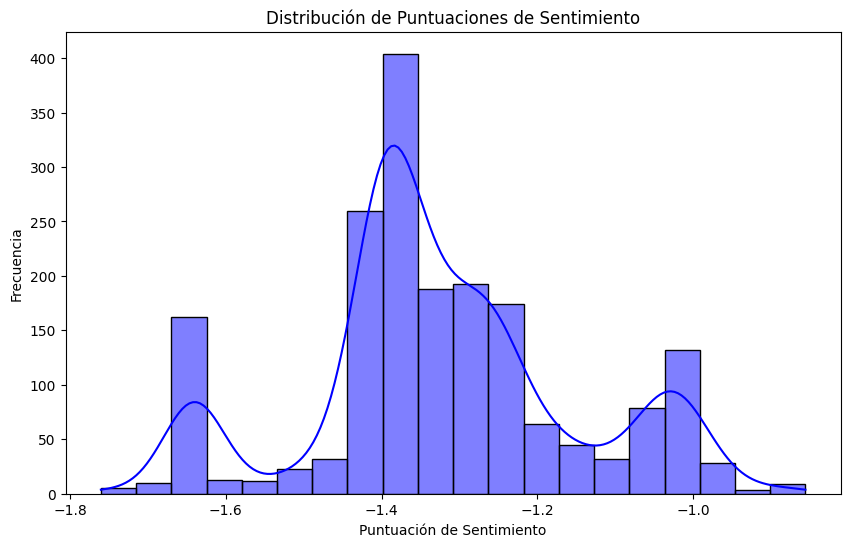

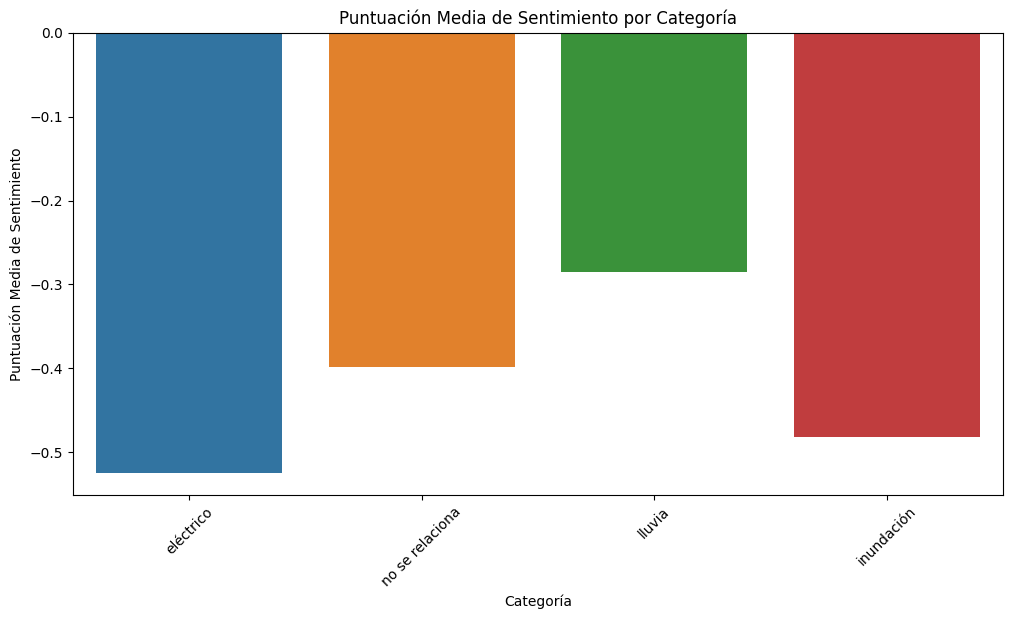

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de puntuaciones de sentimiento
plt.figure(figsize=(10, 6))
sns.histplot(df[f'Puntaje_diferencia_{característica}'], bins=20, kde=True, color='blue')
plt.title('Distribución de Puntuaciones de Sentimiento')
plt.xlabel('Puntuación de Sentimiento')
plt.ylabel('Frecuencia')
plt.show()

# Si tienes una columna con categorías o temas, por ejemplo 'Category'
# Aquí te muestro cómo hacer un gráfico de barras
if 'Tipo' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Tipo', y='Puntaje', data=df, ci=None)
    plt.title('Puntuación Media de Sentimiento por Categoría')
    plt.xlabel('Categoría')
    plt.ylabel('Puntuación Media de Sentimiento')
    plt.xticks(rotation=45)
    plt.show()

# Scatter plot para visualizar la puntuación a lo largo de otra variable (ej. tiempo)
if 'Timestamp' in df.columns:
    plt.figure(figsize=(14, 6))
    sns.scatterplot(x='Timestamp', y='Sentiment_Score', data=df, hue='Sentiment_Score', palette='coolwarm', alpha=0.7)
    plt.title('Puntuación de Sentimiento a lo Largo del Tiempo')
    plt.xlabel('Fecha y Hora')
    plt.ylabel('Puntuación de Sentimiento')
    plt.show()


## Dudas:

Análisis de sentimiento: ¿la forma en la que manejamos el puntaje se le hace adecuada? Una limitante es que el sentimiento se calcula palabra por palabra, por lo que si una palabra es positiva y otra negativa, el sentimiento final puede ser neutro.

La clasificación se le hace adecuada? La categoría no se relaciona tiene Tweets muy negativos y muchos son relacionados con accidentes de tránsito (pero no se especifica si se ocacionó por la lluvia).

Para la geolocalización tenemos que extraer la ubicación del mismo tweet, ya que no se especifica en el dataset. No todos los tweets incluyen la ubicación.
Las ubicaciones varían entre: calles, avenidas, colonias, municipios y estados. 
¿Lo manejamos en capas? 
¿Qué podemos utilizar para la geolocalización? 
¿Un mapa con puntos en las ubicaciones es el adecuado?

Dos infraestructuras: eléctrica y de transporte

Curiel NLP AUTOR
Becarios - pedir apoyo en el etiquetado, 

GEOPANDAS Y OSMNX
sacar el centroide del poligono
Areas geografícas básicas --> Mastra, Andrés, JP
